# Health study report

### Beskrivande analys
Räkna ut medel, median, min och max för: age, weight, height, systolic_bp, cholesterol.
Skapa minst 3 olika grafer (t.ex. histogram över blodtryck, boxplot över vikt per kön, stapeldiagram över andelen rökare).
### Simulering kopplad till caset (använd numpy.random + seed)
Beräkna andelen personer i datasetet som har sjukdomen.
Använd numpy för att simulera 1000 slumpade personer med samma sannolikhet för sjukdom.
Jämför den simulerade andelen med den verkliga andelen i datasetet.
### Konfidensintervall
Beräkna ett konfidensintervall för medelvärdet av systolic_bp (t.ex. med normalapproximation eller bootstrap, som vi gått igenom på kursen).
### Hypotesprövning
Testa hypotesen: ”Rökare har högre medel-blodtryck än icke-rökare.”
Använd en av metoderna vi gått igenom (t.ex. bootstrap eller enkel t-test-funktion).
Förklara kort resultatet i en markdown-ruta.

För VG ska du även göra:

- Beräkna konfidensintervallet med två olika metoder (t.ex. normalapproximation och bootstrap) och jämför resultaten.
- Gör en simulering för att undersöka hur säkert ditt hypotes­test är (t.ex. hur ofta testet hittar en skillnad när den finns → power).
- Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.

In [107]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

REQUIRED = [
    "id", "age", "sex", "height", "weight", "systolic_bp", "cholesterol", "smoker", "disease"
]

def load_data(path: str) -> pd.DataFrame:
    """
    Läser CSV och kontrollerar att alla kolumner som listas i "REQUIRED" finns med.
    """
    df = pd.read_csv("data/health_study_dataset.csv")
    missing = [c for c in REQUIRED if c not in df.columns]
    if missing:
        raise ValueError(f"Saknade kolumner: {missing}")
    return df

def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Säkerställer att numeriska kolumner faktiskt är numeriska.
    """
    out = df.copy()
    for c in ["age", "height", "systolic_bp", "cholesterol", "disease"]:
        out [c] = pd.to_numeric(out[c], errors="coerce")
    return out


In [108]:
df = load_data("data/health_study_dataset.csv")
df = coerce_numeric(df)

display(df.head())
df.info()
print(df.isna().sum()) # kontrollera så det inte finns några NaN-värde

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB
id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64


In [109]:
# medel, median, min och max för age, weight, height, systolic_bp, cholesterol

columns = ["age", "weight", "height", "systolic_bp", "cholesterol"]

for c in columns:
    mean = df[c].mean()
    median = df[c].median()
    min_value = df[c].min()
    max_value = df[c].max()

display(df[["age", "weight", "height", "systolic_bp", "cholesterol"]].describe())


,age,weight,height,systolic_bp,cholesterol
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,49.426250,73.413000,171.849250,149.178625,4.929150
std,14.501118,13.685059,9.804259,12.793360,0.848413
min,18.000000,33.700000,144.400000,106.800000,2.500000
25%,39.000000,64.800000,164.775000,140.900000,4.327500
50%,50.000000,73.200000,171.350000,149.400000,4.970000
75%,59.000000,82.600000,178.925000,157.600000,5.482500
max,90.000000,114.400000,200.400000,185.900000,7.880000


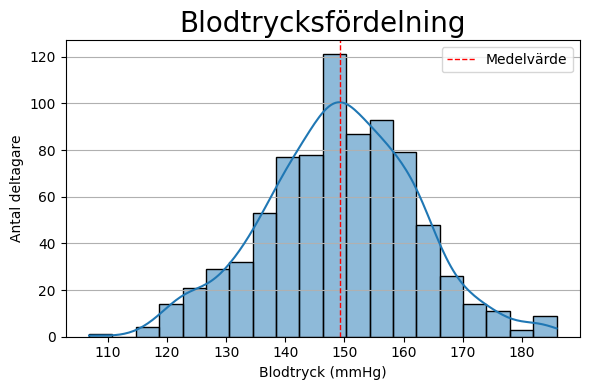

In [110]:
# histogram över blodtryck

import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(df["systolic_bp"], bins=20, edgecolor="black", ax=ax, kde=True)
ax.axvline((df["systolic_bp"]).mean(), color="red", linestyle="--", linewidth="1", label="Medelvärde")
ax.set_title("Blodtrycksfördelning", fontsize=20)
ax.set_xlabel("Blodtryck (mmHg)")
ax.set_ylabel("Antal deltagare")
ax.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

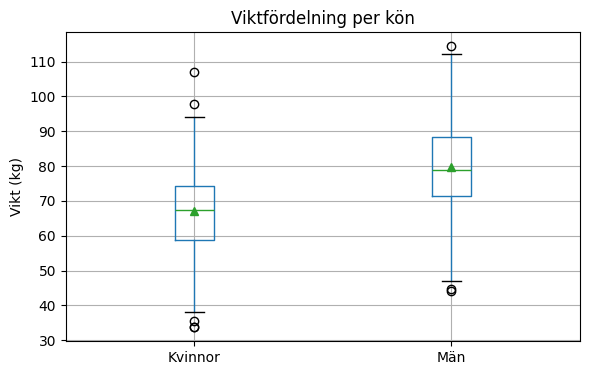

In [111]:
# boxplot över vikt per kön

fig, ax = plt.subplots(figsize=(6, 4))
df.boxplot(column="weight", by="sex", ax=ax, showmeans=True)
ax.set_title("Viktfördelning per kön")
ax.set_xlabel("")
ax.set_ylabel("Vikt (kg)")
ax.set_xticklabels(["Kvinnor", "Män"])
plt.suptitle("") 
plt.tight_layout()
plt.show()


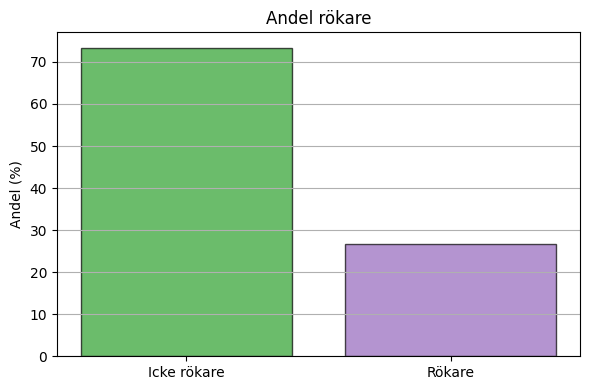

In [118]:
# stapeldiagram över andelen rökare (procent?)

smoker_count = df["smoker"].value_counts(normalize=True)*100

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(smoker_count.index.astype(str), smoker_count.values, alpha=0.7, edgecolor="black", color=["tab:green", "tab:purple"])
ax.set_title("Andel rökare")
ax.set_xlabel("")
ax.set_ylabel("Andel (%)")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Icke rökare", "Rökare"])
ax.grid(True, axis="y")
plt.tight_layout()
plt.show;

In [113]:
# Beräkna andelen som har sjukdomen

sick = df[df["disease"] == 1]
sick = sick.value_counts().sum()

total = len(df)

sick_percent = sick / total * 100

print(f"Antalet med sjukdomen är: {sick} st dvs {sick_percent:.2f}% av deltagarna")

Antalet med sjukdomen är: 47 st dvs 5.88% av deltagarna


In [114]:
# Använd numpy för att simulera 1000 slumpade personer med samma sannolikhet för sjukdomen.
# Jämför den simulerade andelen med den verkliga andelen i datasetet.
# använd numpy.random + seed

np.random.seed(42)

n = 1000
w_disease = sick / total

sim = np.random.choice([0, 1], size=n, p=[1 - w_disease, w_disease])
sim_mean = sim.mean() * 100

print(f"Simulation visar att andelen sjuka är {sim_mean:.2f}%")

Simulation visar att andelen sjuka är 5.60%


In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(w_disease, sim_mean)